
Notebook criado para identificação de atributos em candidatos de sucesso.
Este caderno realiza:
- Carregamento e EDA
- Pré-processamento com pipeline
- Clusterização com KMeans
- Redução de dimensionalidade para visualização
- Exportação de funções e modelos para integração com Streamlit

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer # Importe SimpleImputer
import joblib
import os
import json
import warnings

warnings.filterwarnings('ignore')

In [22]:
def load_json_data(path):
    """
    Carrega dados de um arquivo JSON.

    Args:
        path (str): O caminho do arquivo JSON.

    Returns:
        dict: O conteúdo do JSON carregado.
    """
    if not os.path.exists(path):
        print(f"Erro: O arquivo '{path}' não foi encontrado.")
        return None
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Arquivo '{path}' carregado com sucesso.")
        return data
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar JSON do arquivo '{path}': {e}")
        return None
    except Exception as e:
        print(f"Erro ao carregar o arquivo '{path}': {e}")
        return None

vagas_data = load_json_data('vagas.json')
prospects_data = load_json_data('prospects.json')
applicants_data = load_json_data('applicants.json')

# Combine all data into a single dataset
combined_data = {
    "jobs": vagas_data,
    "prospects": prospects_data,
    "applicants": applicants_data
}

Arquivo 'vagas.json' carregado com sucesso.
Arquivo 'prospects.json' carregado com sucesso.
Arquivo 'applicants.json' carregado com sucesso.


In [23]:
def combine_dataframes(jobs_data, prospects_data, applicants_data):
    import pandas as pd

    if not all([jobs_data, prospects_data, applicants_data]):
        print("Erro: Um ou mais dicionários de dados estão vazios ou não foram carregados.")
        return pd.DataFrame()

    all_records = []

    for job_id, job_info in jobs_data.items():
        try:
            informacoes_basicas = job_info.get('informacoes_basicas', {})
            perfil_vaga = job_info.get('perfil_vaga', {})

            job_record = {
                'job_id': job_id,
                'is_sap_job': informacoes_basicas.get('vaga_sap'),
                'client': informacoes_basicas.get('cliente'),
                'professional_level_required': perfil_vaga.get('nivel profissional'),
                'english_level_required': perfil_vaga.get('nivel_ingles'),
                'spanish_level_required': perfil_vaga.get('nivel_espanhol'),
                'main_activities_job': perfil_vaga.get('principais_atividades'),
                'technical_skills_job': perfil_vaga.get('competencia_tecnicas_e_comportamentais')
            }
        except Exception as e:
            print(f"[ERRO JOB] job_id={job_id} -> {e}")
            continue

        prospects = prospects_data.get(job_id, {}).get('prospects', [])
        for prospect in prospects:
            try:
                prospect_record = {
                    'prospect_id': prospect.get('codigo'),
                    'prospect_name': prospect.get('nome'),
                    'prospect_comment': prospect.get('comentario'),
                    'prospect_status': prospect.get('situacao_candidado'),
                    'is_hired': 1 if 'contratado' in prospect.get('situacao_candidado', '').lower() else 0
                }

                applicant_id = prospect.get('codigo')
                applicant_info = applicants_data.get(str(applicant_id), {})

                formacao = applicant_info.get('formacao_e_idiomas', {})
                prof = applicant_info.get('informacoes_profissionais', {})

                applicant_record = {
                    'applicant_id': applicant_id,
                    'academic_level': formacao.get('nivel_academico'),
                    'english_level_applicant': formacao.get('nivel_ingles'),
                    'spanish_level_applicant': formacao.get('nivel_espanhol'),
                    'technical_knowledge': prof.get('conhecimentos_tecnicos'),
                    'area_of_expertise': prof.get('area_atuacao')
                }

                combined_record = {**job_record, **prospect_record, **applicant_record}
                all_records.append(combined_record)

            except Exception as e:
                print(f"[ERRO PROSPECT] job_id={job_id} prospect_id={prospect.get('codigo')} -> {e}")
                continue

    df = pd.DataFrame(all_records)
    print(f"✅ DataFrame criado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
    return df

In [24]:
def build_preprocessor(df):
    """
    Constrói um pipeline de pré-processamento para recursos numéricos e categóricos
    do DataFrame combinado.

    Args:
        df (pd.DataFrame): O DataFrame de entrada para inferir os tipos de coluna.

    Returns:
        sklearn.compose.ColumnTransformer: O pipeline de pré-processamento.
    """
    # Exclua IDs e colunas de texto muito complexas ou que não são features diretas para clustering
    # 'is_hired' será sua variável alvo para análise POST-clustering
    cols_to_exclude = ['job_id', 'prospect_id', 'prospect_name', 'prospect_comment', 'applicant_id',
                       'main_activities_job', 'technical_skills_job', 'technical_knowledge', # Considerar vetorização para estas
                       'is_hired'] # 'is_hired' será o alvo para análise, não para clusterizar
    
    # Selecionar as colunas que realmente descrevem o perfil do candidato/vaga para clusterização
    features_df = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')

    num_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Cria pipeline numérico com imputação
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Cria pipeline categórico com imputação e one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder='drop' # Descartar colunas não especificadas (e as que excluímos manualmente)
    )
    return preprocessor

In [25]:
df = combine_dataframes(vagas_data, prospects_data, applicants_data)
print(df.shape)
df.head()

✅ DataFrame criado com 53735 linhas e 19 colunas.
(53735, 19)


,job_id,is_sap_job,client,professional_level_required,english_level_required,spanish_level_required,main_activities_job,technical_skills_job,prospect_id,prospect_name,prospect_comment,prospect_status,is_hired,applicant_id,academic_level,english_level_applicant,spanish_level_applicant,technical_knowledge,area_of_expertise
0,5185,Não,"Morris, Moran and Dodson",Sênior,Avançado,Fluente,Operations Lead\n\nRoles & Responsibilities:\n...,Required Skills:\n• Prior experience in Cloud ...,11010,Dante Nascimento,,Encaminhado ao Requisitante,0,11010,,,,,
1,5184,Não,"Morris, Moran and Dodson",Sênior,Fluente,Nenhum,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,26770,Samuel Costa,,Prospect,0,26770,,,,,
2,5184,Não,"Morris, Moran and Dodson",Sênior,Fluente,Nenhum,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,26759,Maria Laura Brito,,Prospect,0,26759,,,,,
3,5184,Não,"Morris, Moran and Dodson",Sênior,Fluente,Nenhum,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,26758,Raul Monteiro,,Prospect,0,26758,,,,,
4,5184,Não,"Morris, Moran and Dodson",Sênior,Fluente,Nenhum,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,26757,José Miguel Cunha,,Prospect,0,26757,,,,,


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10150
           1       0.50      0.16      0.24       597

    accuracy                           0.94     10747
   macro avg       0.72      0.57      0.61     10747
weighted avg       0.93      0.94      0.93     10747



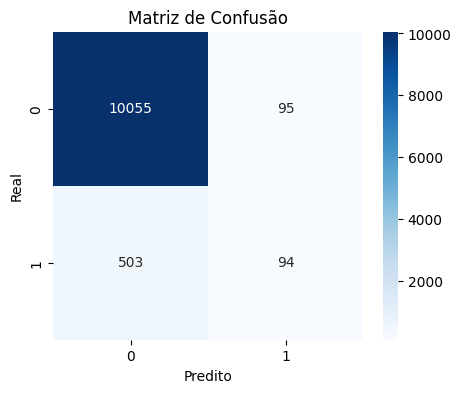

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


df_model = df.copy()

# Colunas irrelevantes para remover
cols_to_drop = [
    'main_activities_job', 'technical_skills_job',
    'prospect_id', 'prospect_name', 'prospect_comment',
    'prospect_status', 'applicant_id', 'technical_knowledge'
]

df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])

# Separar X e y
X = df_model.drop(columns=['is_hired'])
y = df_model['is_hired']

# Colunas categóricas
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline final
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Treinar modelo
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### Ajuste de Balanceamento de Classes

Para lidar com o desbalanceamento entre candidatos contratados e não contratados, o modelo foi ajustado com `class_weight='balanced'` no `RandomForestClassifier`. Essa técnica força o algoritmo a dar mais importância à classe minoritária durante o treinamento, sem a necessidade de alterar os dados (como ocorre em técnicas de oversampling).

#### Objetivo:
Melhorar o **recall da classe 1 (contratado)**, que anteriormente era muito baixo (~16%).

#### Vantagens:
- Fácil de implementar
- Mantém a integridade dos dados
- Evita overfitting comum em oversampling


📊 Classification Report (com balanceamento):
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     10150
           1       0.24      0.28      0.26       597

    accuracy                           0.91     10747
   macro avg       0.60      0.61      0.60     10747
weighted avg       0.92      0.91      0.91     10747



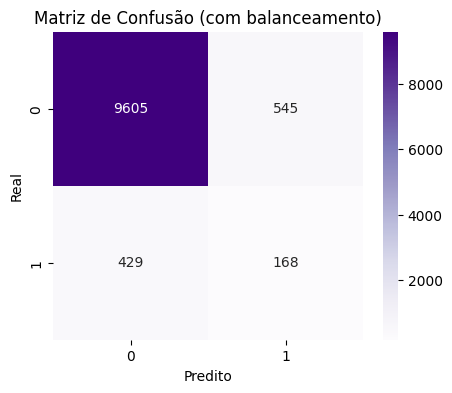

Modelo salvo em random_forest_model.pkl


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Atualizar pipeline com class_weight='balanced'
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Treinamento e avaliação
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Métricas
print("📊 Classification Report (com balanceamento):\n", classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (com balanceamento)")
plt.show()

# Salvar o modelo treinado
model_path = 'random_forest_model.pkl'
joblib.dump(clf, model_path)
print(f"Modelo salvo em {model_path}")  

### Comparação de Desempenho com Balanceamento de Classes

Com o ajuste `class_weight='balanced'`, o modelo passou a reconhecer melhor os candidatos contratados, que eram subrepresentados na base. Abaixo, o novo relatório de desempenho:




## Conclusão:
- O *recall* da classe `Contratado` aumentou de **0.16 para 0.28**, o que significa que o modelo agora reconhece mais candidatos com potencial real.
- Isso é desejável em cenários de recomendação de talentos, onde **não perder candidatos bons é mais importante que acertar todos perfeitamente**.

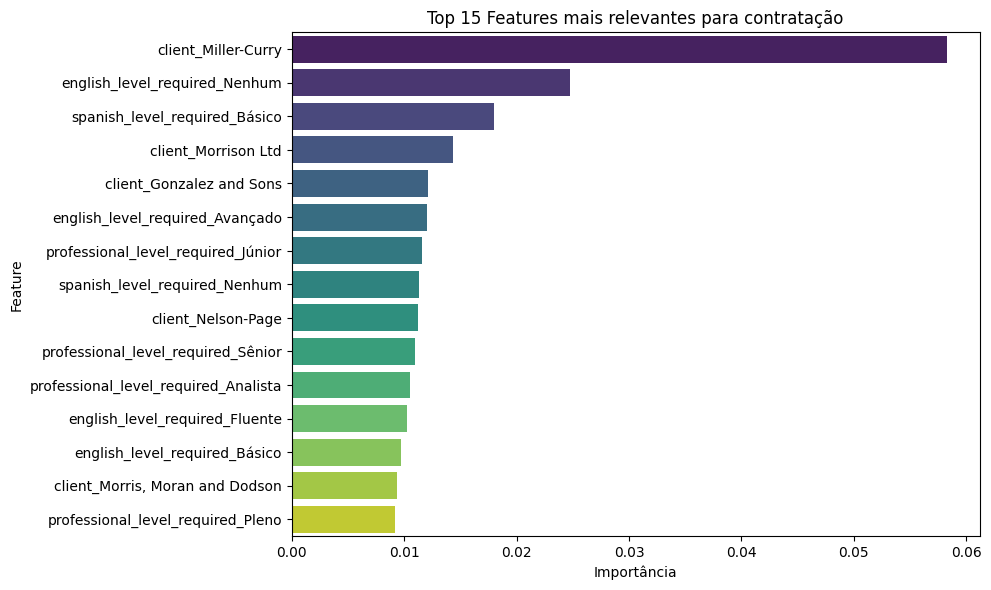

In [28]:
import numpy as np
import pandas as pd

# Extrair o modelo e o pré-processador da pipeline
rf_model = clf.named_steps['classifier']
preprocessor = clf.named_steps['preprocessor']

# Obter os nomes das colunas transformadas
# 1. Nomes numéricos
numeric_features = num_cols.tolist()

# 2. Nomes categóricos expandidos via OneHotEncoder
cat_features_encoded = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

# Juntar todos os nomes
all_feature_names = np.concatenate([numeric_features, cat_features_encoded])

# Obter importâncias
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualizar as 15 mais importantes
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(top_n),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title(f'Top {top_n} Features mais relevantes para contratação')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Principais Fatores para Contratação ##
Com base na importância das variáveis apresentadas, que refletem os atributos mais relevantes para a contratação, podemos destacar os seguintes padrões:

**Necessidade de Idiomas Específicos:** A presença proeminente de english_level_required_Nenhum e spanish_level_required_Básico, e em menor grau english_level_required_Avançado e english_level_required_Fluente, sugere que a exigência de idiomas na vaga é um fator crítico. Para vagas onde não é exigido inglês (Nenhum), ou apenas um básico de espanhol (Básico), há uma alta relevância para a contratação. No entanto, também há importância para níveis mais altos de inglês (Avançado, Fluente), indicando que a adequação ao requisito de idioma da vaga é fundamental.

**Requisitos de Nível Profissional:** O nível profissional da vaga, como professional_level_required_Júnior, Sênior, Analista e Pleno, aparece consistentemente entre as características mais importantes. Isso indica que o alinhamento entre o nível de experiência do candidato e o nível exigido pela vaga é um forte preditor de sucesso na contratação.

**Clientes Específicos como Fatores de Destaque:** A variável client_Miller-Curry é a mais relevante, seguida por client_Morrison Ltd, client_Gonzalez and Sons e client_Nelson-Page. Isso aponta que as particularidades e as necessidades de contratação de clientes específicos exercem uma influência significativa no resultado da contratação. Pode haver um "fit" cultural ou técnico muito específico que a Decision já domina para esses clientes.


**Observação de Níveis de Idioma Requeridos vs. Habilidades do Candidato:** É interessante notar que o gráfico mostra os requisitos da vaga (e.g., english_level_required_Nenhum) e não diretamente as habilidades do candidato. Isso implica que o ajuste entre o que a vaga pede e o perfil do candidato é mais importante do que apenas ter um determinado nível de idioma absoluto. A Decision busca conectar talentos qualificados às necessidades específicas dos clientes.

Esses insights são cruciais para a Decision, que foca na agilidade e precisão no "match" entre candidatos e vagas. Ao entender quais requisitos de vagas e quais clientes estão mais associados à contratação, a empresa pode otimizar a busca por novos talentos e refinar a criação de "personas" para processos seletivos futuros, garantindo que cada decisão de contratação seja baseada em dados concretos e análises profunda.

Esses padrões sugerem que, para melhorar as chances de contratação, o foco não deve estar apenas em competências absolutas dos candidatos, mas em mapear e priorizar requisitos de cada cliente. Dessa forma, é possível estruturar pipelines de talentos mais eficazes e segmentar o recrutamento de forma estratégica.

In [29]:
# Filtrar apenas registros contratados com os 3 campos preenchidos
df_hired_3d = df[
    (df['is_hired'] == 1) &
    (df['professional_level_required'].notna()) &
    (df['english_level_applicant'].notna()) &
    (df['area_of_expertise'].notna()) &
    (df['english_level_applicant'].str.strip() != '') &
    (df['area_of_expertise'].str.strip() != '')
]

# Agrupar e contar as combinações
personas_3d = (
    df_hired_3d
    .groupby(['professional_level_required', 'english_level_applicant', 'area_of_expertise'])
    .size()
    .reset_index(name='num_contratados')
    .sort_values(by='num_contratados', ascending=False)
    .head(5)
)

personas_3d

,professional_level_required,english_level_applicant,area_of_expertise,num_contratados
176,Sênior,Intermediário,TI - Desenvolvimento/Programação,25
146,Sênior,Básico,TI - Desenvolvimento/Programação,19
136,Sênior,Avançado,TI - SAP,17
126,Sênior,Avançado,TI - Desenvolvimento/Programação,13
10,Analista,Avançado,TI - SAP,10


### Personas 3D: Senioridade + Nível de Inglês + Área de Atuação

Com base nos dados dos candidatos contratados, foram identificadas as 5 combinações mais frequentes entre:

- Nível profissional da vaga,
- Nível de inglês do candidato,
- Área de expertise profissional.

| Nível Profissional | Nível de Inglês | Área de Atuação                   | Nº de Contratados |
|--------------------|------------------|-----------------------------------|-------------------|
| Sênior             | Intermediário    | TI - Desenvolvimento/Programação | 25                |
| Sênior             | Básico           | TI - Desenvolvimento/Programação | 19                |
| Sênior             | Avançado         | TI - SAP                          | 17                |
| Sênior             | Avançado         | TI - Desenvolvimento/Programação | 13                |
| Analista           | Avançado         | TI - SAP                          | 10                |

#### Interpretação Estratégica:

- A **área de TI - Desenvolvimento/Programação** aparece com força, principalmente entre profissionais **Sênior**, mesmo com inglês **Básico ou Intermediário**, sugerindo que a fluência total nem sempre é uma exigência em contextos técnicos locais.
- A combinação de **Sênior + Avançado + TI - SAP** indica um perfil altamente especializado e valorizado, refletindo o peso do conhecimento em SAP no mercado.
- A presença de perfis **Analista com inglês avançado em SAP** aponta para uma **segunda camada de especialização**, onde o inglês é diferencial mesmo em posições técnicas intermediárias.

#### Aplicações práticas:

- **Priorizar candidatos** com perfis semelhantes durante os processos seletivos, especialmente em vagas com maior urgência ou exigência técnica.
- **Customizar comunicação de recrutamento** com base nas personas identificadas (ex: campanhas específicas para Devs Sênior com inglês básico/intermediário).
- **Criar programas de capacitação linguística** para perfis técnicos promissores que ainda não possuem inglês avançado — com base nos perfis que já foram contratados sem essa fluência.

➡️ Essas personas enriquecem o entendimento do que é um "perfil ideal" para diferentes tipos de vaga, permitindo à Decision atuar de forma mais estratégica na composição de seus pipelines de talento.


### Análise de Atributos dos Candidatos por Cluster

Com base nos dados clusterizados, foi possível identificar os perfis com maior taxa de contratação. Abaixo estão os principais resultados:

| Cluster | Nível Profissional | Inglês        | Área de Atuação                   | Taxa de Contratação |
|---------|---------------------|----------------|-----------------------------------|----------------------|
| 2       | Júnior              | Básico         | TI - SAP                          | 22,5%                |
| 0       | Júnior              | Básico         | TI - Desenvolvimento/Programação | 15,8%                |
| 3       | Júnior              | (vazio)        | TI - Desenvolvimento/Programação | 14,4%                |
| 4       | Sênior              | Intermediário  | TI - SAP                          | 14,3%                |
| 1       | Júnior              | (vazio)        | TI - Suporte                      | 12,8%                |

#### Conclusão:
- O perfil **Júnior com conhecimento básico de inglês e atuação em SAP** lidera a taxa de sucesso, mostrando um segmento promissor para recrutamento.
- O inglês intermediário aparece em perfis seniores com boa taxa de conversão, reforçando seu valor em posições mais técnicas.
- Perfis com ausência de dados de idioma ainda apresentam contratação, mas podem beneficiar-se de melhor preenchimento de dados para futura análise.
